**Introduction:**

I have prepared the Powerlifting dataset from Kaggle for a future analysis. Here is the link: https://www.kaggle.com/open-powerlifting/powerlifting-database

I would like to note that this is only an outdated snapshot of the real database.  https://www.openpowerlifting.org/  is the source for this dataset.

**IMPORTS**

* Pandas for manipulating the Data Frame
* Numpy for computing data
* os to import data set
* matplotlib.pyplot and seaborn for plotting data
* sklearn for clustering data

In [8]:
#Load packages
import os
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.cluster import KMeans

In [10]:
#Read in and clean the data 
powerlift = pd.read_csv('openpowerlifting.csv')

select_columns = [
       'MeetID', 'Name', 'Sex', 'Equipment',
       'BodyweightKg', 'WeightClassKg', 'BestSquatKg',
       'BestBenchKg',  'BestDeadliftKg',
       'TotalKg', 'Wilks']

powerlift = powerlift[select_columns]

powerlift[['BestSquatKg', 'BestBenchKg', 'BestDeadliftKg']] = \
            powerlift[['BestSquatKg', 'BestBenchKg', 'BestDeadliftKg']].fillna(0)

powerlift['TotalKg'] = powerlift['BestSquatKg'] + \
                        powerlift['BestBenchKg'] + powerlift['BestDeadliftKg']

#remove nan in BodyweightKg row less than 1% is affected by this
powerlift = powerlift.dropna(subset=['BodyweightKg'])

powerlift.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 384012 entries, 0 to 386413
Data columns (total 11 columns):
MeetID            384012 non-null int64
Name              384012 non-null object
Sex               384012 non-null object
Equipment         384012 non-null object
BodyweightKg      384012 non-null float64
WeightClassKg     381602 non-null object
BestSquatKg       384012 non-null float64
BestBenchKg       384012 non-null float64
BestDeadliftKg    384012 non-null float64
TotalKg           384012 non-null float64
Wilks             362194 non-null float64
dtypes: float64(6), int64(1), object(4)
memory usage: 35.2+ MB


**WILKS SCORE:**

Some of the values in the "Wilks" column are Null values, but There is enough information for us to fill these values.

In [11]:
#functions for wilks score
def male_wilks(weight, totalkg):
    coeff = 500 / (-216.0475144 + 
                   (16.2606339 * weight) + 
                   (-0.002388645 * weight**2) + 
                   (-0.00113732 * weight**3) + 
                   (7.01863E-06 * weight**4) + 
                   (-1.291E-08 * weight**5))
    wilks = round(coeff * totalkg, 2)
    return wilks


def female_wilks(weight, totalkg):
    coeff = 500 / (594.31747775582 +
                  (-27.23842536447 * weight) +
                  (0.82112226871 * weight**2) +
                  (-0.00930733913 * weight**3) +
                  (4.731582E-05 * weight**4) +
                  (-9.054E-08 * weight**5))
    wilks = round(coeff * totalkg, 2)
    return wilks


#recalculate wilks column to fill in Nan
men = (powerlift['Sex'] != 'F')
powerlift_valid = powerlift[men]
powerlift.loc[men, 'Wilks'] = male_wilks(powerlift_valid['BodyweightKg'], 
                                          powerlift_valid['TotalKg'])

women = (powerlift['Sex'] != 'M')
powerlift_valid = powerlift[women]
powerlift.loc[women, 'Wilks'] = male_wilks(powerlift_valid['BodyweightKg'], 
                                          powerlift_valid['TotalKg'])

powerlift.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 384012 entries, 0 to 386413
Data columns (total 11 columns):
MeetID            384012 non-null int64
Name              384012 non-null object
Sex               384012 non-null object
Equipment         384012 non-null object
BodyweightKg      384012 non-null float64
WeightClassKg     381602 non-null object
BestSquatKg       384012 non-null float64
BestBenchKg       384012 non-null float64
BestDeadliftKg    384012 non-null float64
TotalKg           384012 non-null float64
Wilks             384012 non-null float64
dtypes: float64(6), int64(1), object(4)
memory usage: 35.2+ MB


**Simplifying the 'WeightClassKg' columns:**


To simplify the categorical data in 'WeightClassKg' I aggregated it. I now have a new column with three distinct options that reflect the federation type. There are two types of federations that are common to competing powerlifters, IPF and non-IPF. Anything that falls outside of these I considered as an 'Abnormal Federation'. Here's a link that dives into the federation types.
https://www.powerliftingtowin.com/how-to-pick-your-weight-class/

At the end of the cell you will see that I spent extra time to determine a 52kg competitor. 52kg is unique as it is an option in both IPF and non-IPF competitions.

In [12]:

#remove duplicate rows
powerlift = powerlift.drop_duplicates().reset_index(drop=True)

#remove nan for WeightClassKg rows less than 1% is affected by this
powerlift = powerlift.dropna(subset=['WeightClassKg'])

#aggergate categorical variables WeightClass into federation
IPF = 'IPF'
Other_Feds = 'Not IPF'
not_common ='Abnormal Federation'

IPF_weightclass = ['47', '57', '59', '63', '66', '72', '74', '83', '84', '84+',
                   '93', '105', '120', '120+']
other_fed_weightclass = ['44', '48','56', '60', '67.5', '75', '82.5', '90', 
                         '90+', '100', '110', '125', '140', '140+']
abnormal_weightclass = ['30', '34', '35', '39', '40', '43', '50', '53', '60+', 
                        '67.5', '67.5+', '70', '70+', '75+', '80', '83+', '84+', 
                        '90+', '95', '155', '100+', '110+', '117.5', '125',
                        '125+', '145']

powerlift.loc[powerlift['WeightClassKg'].isin(IPF_weightclass),
             'Federation'] = IPF
powerlift.loc[powerlift['WeightClassKg'].isin(other_fed_weightclass),
             'Federation'] = Other_Feds
powerlift.loc[powerlift['WeightClassKg'].isin(abnormal_weightclass),
             'Federation'] = not_common


#determine which federation 52kg belongs because IPF and Not IPF have this weightclass
#creats a list of unique MeetID numbers for IPF and Not IPF

IP_Fed = powerlift[powerlift['Federation'] == 'IPF']
IP_Fed = IP_Fed['MeetID'].unique().tolist()

NotIP_Fed = powerlift[powerlift['Federation'] == 'Not IPF']
NotIP_Fed = NotIP_Fed['MeetID'].unique().tolist()
NotIP_Fed.extend([531, 1263, 2074])

powerlift.loc[powerlift['MeetID'].isin(IP_Fed),
             'Federation'] = IPF
powerlift.loc[powerlift['MeetID'].isin(NotIP_Fed),
             'Federation'] = Other_Feds

powerlift.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 361854 entries, 0 to 364169
Data columns (total 12 columns):
MeetID            361854 non-null int64
Name              361854 non-null object
Sex               361854 non-null object
Equipment         361854 non-null object
BodyweightKg      361854 non-null float64
WeightClassKg     361854 non-null object
BestSquatKg       361854 non-null float64
BestBenchKg       361854 non-null float64
BestDeadliftKg    361854 non-null float64
TotalKg           361854 non-null float64
Wilks             361854 non-null float64
Federation        361854 non-null object
dtypes: float64(6), int64(1), object(5)
memory usage: 35.9+ MB


**Simplifying numberic columns into quartiles:**
I created some category columns using quartiles for the numeric values. I did this to give an intuitive understanding to the numbers. 

In [13]:
#seperate categories into quartiles

Squat_weight = ['Very Light Squat', 'Light Squat',
               'Moderate Squat', 'Heavy Squat', 
                'Very Heavy Squat']

powerlift['Squat Weight'] = pd.qcut(powerlift['BestSquatKg'], 5,
                                   Squat_weight)

Bench_weight = ['Very Light Bench', 'Light Bench',
               'Moderate Bench', 'Heavy Bench',
               'Very Heavy Bench']

powerlift['Bench Weight'] = pd.qcut(powerlift['BestBenchKg'], 5, 
                                   Bench_weight)

Deadlift_weight = ['Very Light DL', 'Light DL', 
                  'Moderate DL', 'Heavy DL',
                  'Very Heavy DL']

powerlift['Deadlift Weight'] = pd.qcut(powerlift['BestDeadliftKg'], 5,
                                      Deadlift_weight)

Total_weight = ['Very Light Total', 'Light Total', 
               'Moderate Total', 'Heavy Total', 
               'Very Heavy Total']

powerlift['Total Weight'] = pd.qcut(powerlift['TotalKg'], 5, 
                                   Total_weight)

WILKS = ['Very Low WILKS', 'Low WILKS', 
         'Moderate WILKS', 'Hight WILKS', 
         'Very Hight WILKS']

powerlift['WILKS Level'] = pd.qcut(powerlift['Wilks'], 5, 
                                  WILKS)
powerlift.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361854 entries, 0 to 364169
Data columns (total 17 columns):
MeetID             361854 non-null int64
Name               361854 non-null object
Sex                361854 non-null object
Equipment          361854 non-null object
BodyweightKg       361854 non-null float64
WeightClassKg      361854 non-null object
BestSquatKg        361854 non-null float64
BestBenchKg        361854 non-null float64
BestDeadliftKg     361854 non-null float64
TotalKg            361854 non-null float64
Wilks              361854 non-null float64
Federation         361854 non-null object
Squat Weight       361854 non-null category
Bench Weight       361854 non-null category
Deadlift Weight    361854 non-null category
Total Weight       361854 non-null category
WILKS Level        361854 non-null category
dtypes: category(5), float64(6), int64(1), object(5)
memory usage: 37.6+ MB


**Clustering to create a new category:**

In the next two cells I used clustering to create a new column that tells us how heavy a lifter is and how strong they are.
I used a heat map to use visualization as a better way to view our clustering results.

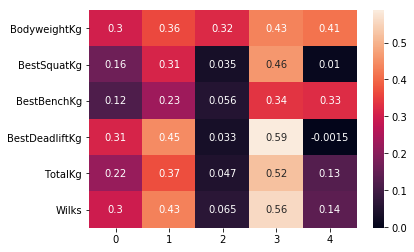

In [14]:
cluster_columns = ['BodyweightKg', 'BestSquatKg', 'BestBenchKg',
                  'BestDeadliftKg', 'TotalKg', 'Wilks']

scaler = preprocessing.MaxAbsScaler()


powerlift_cluster = scaler.fit_transform(powerlift[cluster_columns])
powerlift_cluster = pd.DataFrame(powerlift_cluster, 
                                columns=cluster_columns)

#cluster function


def kmeans_cluster(df, n_clusters=2):
    model = KMeans(n_clusters=n_clusters, random_state=1)
    clusters = model.fit_predict(df)
    cluster_results = df.copy()
    cluster_results['Cluster'] = clusters
    return cluster_results

#summarizes clusters


def summarize_clustering(results):
    cluster_size = results.groupby(['Cluster']).size().reset_index()
    cluster_means = results.groupby(['Cluster'],
                                   as_index=False).mean()
    cluster_summary = pd.merge(cluster_size, 
                              cluster_means, on='Cluster')
    return cluster_summary


cluster_results = kmeans_cluster(powerlift_cluster, 5)
cluster_summary = summarize_clustering(cluster_results)

sns.heatmap(cluster_summary[cluster_columns].transpose(),
           annot=True)
plt.show()

In [15]:
pd.options.mode.chained_assignment = None  #to remove warnings

cluster_results['Cluster Name'] = ''
cluster_results['Cluster Name'][cluster_results['Cluster']==0] = \
                'Average and Average'
cluster_results['Cluster Name'][cluster_results['Cluster']==1] = \
                'Average and Strong'
cluster_results['Cluster Name'][cluster_results['Cluster']==2] = \
                'Average and Weak'
cluster_results['Cluster Name'][cluster_results['Cluster']==3] = \
                'Heavy and Strong'
cluster_results['Cluster Name'][cluster_results['Cluster']==4] = \
                'Heavy and Weak'

powerlift = powerlift.reset_index().drop('index', axis=1)
powerlift['Cluster Name'] = cluster_results['Cluster Name']
powerlift.info()
powerlift.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361854 entries, 0 to 361853
Data columns (total 18 columns):
MeetID             361854 non-null int64
Name               361854 non-null object
Sex                361854 non-null object
Equipment          361854 non-null object
BodyweightKg       361854 non-null float64
WeightClassKg      361854 non-null object
BestSquatKg        361854 non-null float64
BestBenchKg        361854 non-null float64
BestDeadliftKg     361854 non-null float64
TotalKg            361854 non-null float64
Wilks              361854 non-null float64
Federation         361854 non-null object
Squat Weight       361854 non-null category
Bench Weight       361854 non-null category
Deadlift Weight    361854 non-null category
Total Weight       361854 non-null category
WILKS Level        361854 non-null category
Cluster Name       361854 non-null object
dtypes: category(5), float64(6), int64(1), object(6)
memory usage: 37.6+ MB


,MeetID,Name,Sex,Equipment,BodyweightKg,WeightClassKg,BestSquatKg,BestBenchKg,BestDeadliftKg,TotalKg,Wilks,Federation,Squat Weight,Bench Weight,Deadlift Weight,Total Weight,WILKS Level,Cluster Name
0,0,Angie Belk Terry,F,Wraps,59.60,60,47.63,20.41,70.31,138.35,118.72,Not IPF,Light Squat,Very Light Bench,Very Light DL,Very Light Total,Very Low WILKS,Average and Weak
1,0,Dawn Bogart,F,Single-ply,58.51,60,142.88,95.25,163.29,401.42,350.41,Not IPF,Moderate Squat,Moderate Bench,Moderate DL,Moderate Total,Hight WILKS,Average and Strong
2,0,Dawn Bogart,F,Raw,58.51,60,0.00,95.25,0.00,95.25,83.15,Not IPF,Very Light Squat,Moderate Bench,Very Light DL,Very Light Total,Very Low WILKS,Average and Weak
3,0,Destiny Dula,F,Raw,63.68,67.5,0.00,31.75,90.72,122.47,99.09,Not IPF,Very Light Squat,Very Light Bench,Very Light DL,Very Light Total,Very Low WILKS,Average and Weak
4,0,Courtney Norris,F,Wraps,62.41,67.5,170.10,77.11,145.15,392.36,323.06,Not IPF,Moderate Squat,Light Bench,Light DL,Moderate Total,Hight WILKS,Average and Average
